# Exercise 1 

In this exercise, we will work with the `Mastercard_stock_history.csv` data file. This file contains historical MasterCard stock price information from May-2006 to Oct-2021. The goal is to build `LSTM` models, using `TensorFlow`, to forecast `Close` prices.

### Exercise 1(a) (2 points)

Load the below libraries.

```
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
```

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf

### Exercise 1(b) (3 points)

Read the `Mastercard_stock_history.csv` data file and create a data frame called `df`. Make sure `Date` is a in the appropriate `datetime` format.

In [3]:
df = pd.read_csv('Mastercard_stock_history.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2006-05-25,3.748967,4.283869,3.739664,4.279217,395343000,0.0,0.0
1,2006-05-26,4.307126,4.348058,4.103398,4.179680,103044000,0.0,0.0
2,2006-05-30,4.183400,4.184330,3.986184,4.093164,49898000,0.0,0.0
3,2006-05-31,4.125723,4.219679,4.125723,4.180608,30002000,0.0,0.0
4,2006-06-01,4.179678,4.474572,4.176887,4.419686,62344000,0.0,0.0


### Exercise 1(c) (3 points)

Create a time-series plot of `Close`. 

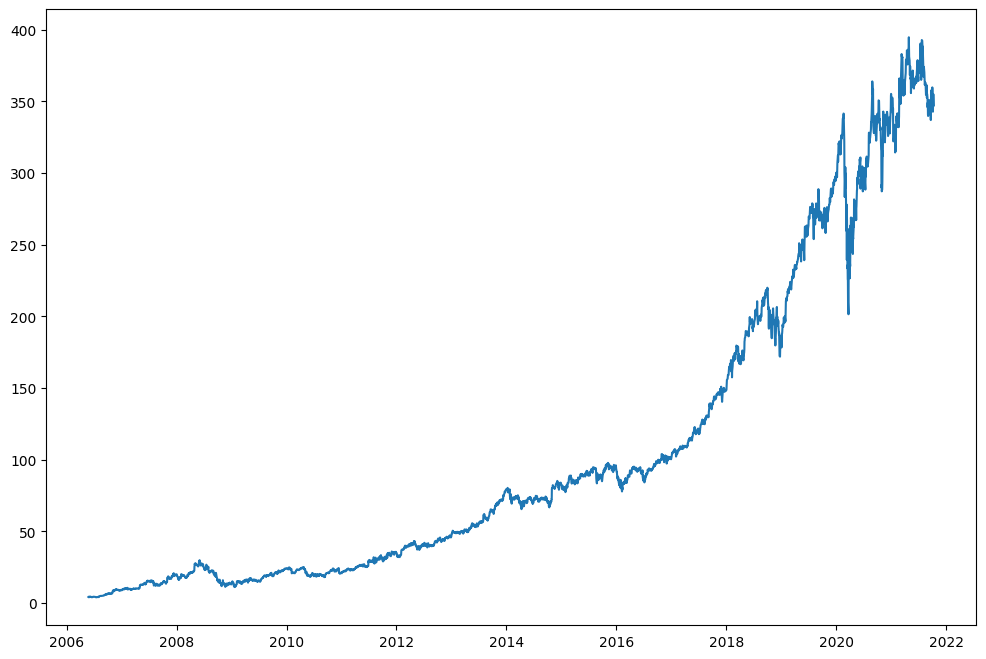

In [4]:
plt.figure(figsize=(12,8))

plt.plot(df['Date'], df['Close'], label='Close price')

### Exercise 1(d) (5 points)

Split the data into `train` (`Close` observations up to 12-31-2020) and `test` (`Close` observations starting from 01-01-2021). Visualize both data sets.

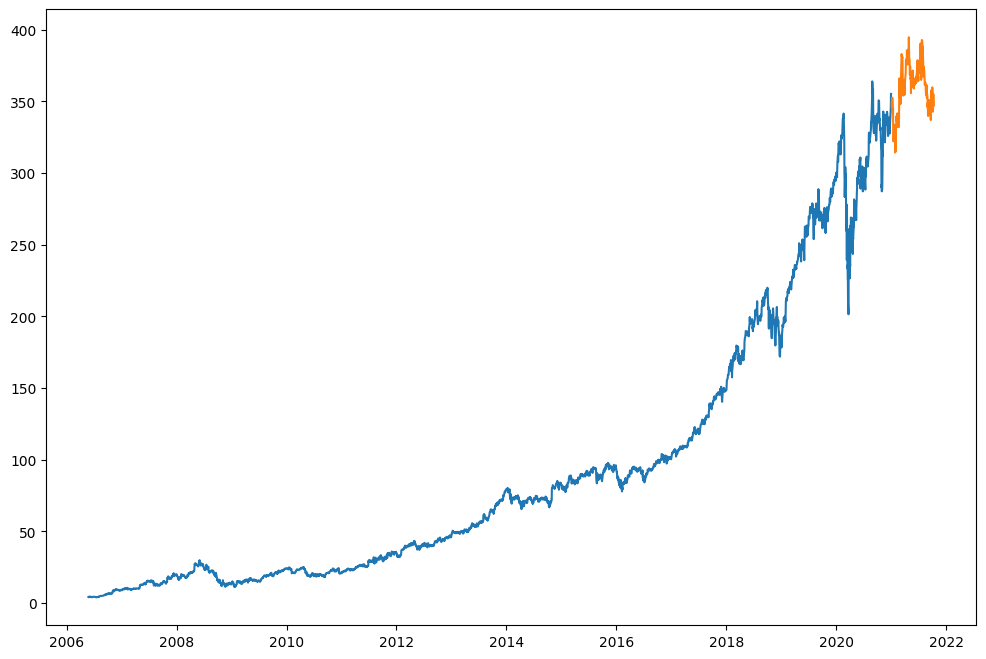

In [5]:
fig = plt.figure(figsize=(12,8))

plt.plot('Date', 'Close', data = df[df['Date']<= pd.to_datetime('12-31-2020')], label='training')
plt.plot('Date', 'Close', data = df[df['Date'] > pd.to_datetime('12-31-2020')], label='testing')

In [6]:
train = df[df['Date'] <= pd.to_datetime('12-31-2020')]['Close'].values.reshape(-1,1)
test = df[df['Date'] > pd.to_datetime('12-31-2020')]['Close'].values.reshape(-1,1)

### Exercise 1(e) (3 points)

Standardize the data using the `StandardScaler` from `sklearn.preprocessing`.

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(train)
train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

### Exercise 1(f) (8 points)

Create a function called `convert_time_series` that takes two arguments: `sequence` (the time series) and `n_steps` (time window). Notice that this function converts the time-series task into a regression task. Convert the `train` and `test` time-series into inputs and outputs using the `convert_time_series` and `n_steps=100`. 

In [9]:
def convert_ts(sequence, n_steps):
    X, y = [],[]
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)
        
n_steps = 100
X_train, y_train = convert_ts(train_scaled, n_steps)
X_test, y_test = convert_ts(test_scaled, n_steps)

### Exercise 1(g) (10 points)

Build a `LSTM` model as follows:

- 50 units and `activation=tanh`. 
- `optimizer="RMSprop"` and `loss='mae'`.

Then, 

- Train the model over 10 time-series folds (use `TimeSeriesSplit` from `sklearn.model_selection` with `test_size=195`). 
- Use `epochs=20` and `batch_size=32`.
- Report the average mean absolute error. 
- Re-train the model using the entire train data set and predict on the test data set.
- Visualize the model predictions with true values.

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

md1 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(50, activation='tanh', input_shape=(100,1)),
    tf.keras.layers.Dense(1)                        
])

md1.compile(optimizer='RMSprop', loss='mae')

scores = []
tscv = TimeSeriesSplit(n_splits=10, test_size=195)

for i,(train_idx, test_idx) in enumerate(tscv.split(X_train)):

    X_train_cv, y_train_cv = X_train[train_idx], y_train[train_idx]
    X_test_cv, y_test_cv = X_train[test_idx], y_train[test_idx]
    
    md1.fit(X_train_cv, y_train_cv, epochs = 20, batch_size=32, validation_data=(X_test_cv,y_test_cv), verbose=0)
    score = md1.evaluate(X_test_cv, y_test_cv, verbose=0, batch_size=32)
    scores.append(score)
    print(f'Fold {i+1} score: {score}')
    
print('mean score:', np.mean(scores))

c:\Users\gmgma\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fold 1 score: 0.010979260317981243
Fold 2 score: 0.020359467715024948
Fold 3 score: 0.012075257487595081
Fold 4 score: 0.015026616863906384
Fold 5 score: 0.009492793120443821
Fold 6 score: 0.02081734873354435
Fold 7 score: 0.02241363935172558
Fold 8 score: 0.03679946810007095
Fold 9 score: 0.05161643773317337
Fold 10 score: 0.08551866561174393
mean score: 0.028509895503520965


In [13]:
md1.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

test_loss = md1.evaluate(X_test, y_test, batch_size=32, verbose=0)

print('test loss:', test_loss)

test loss: 0.04486193507909775


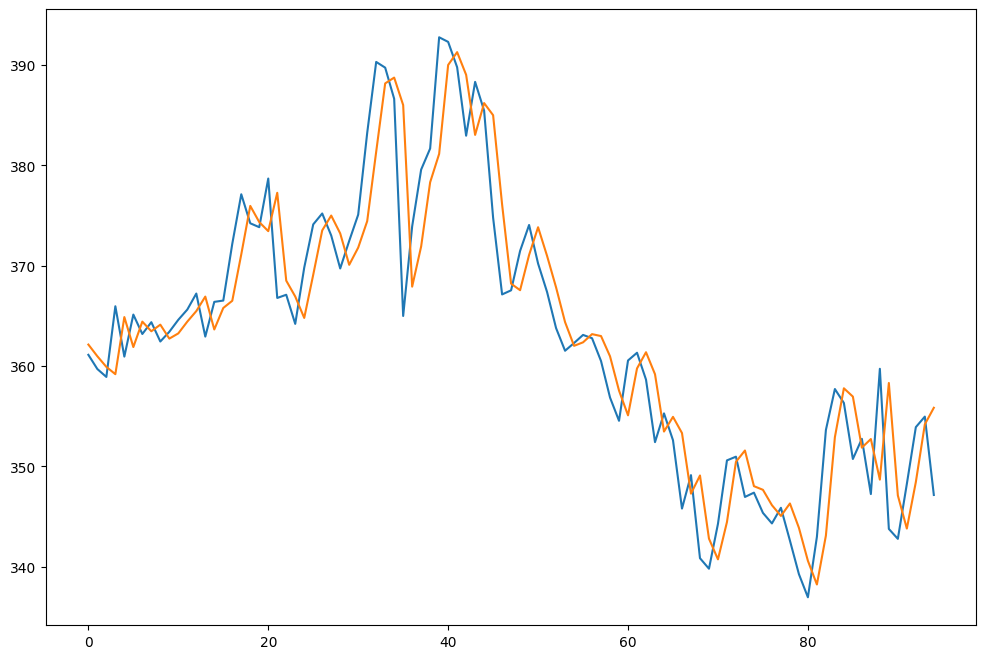

In [15]:
y_pred = md1.predict(X_test, verbose=0, batch_size=32)

y_pred_raw = scaler.inverse_transform(y_pred)
y_test_raw = scaler.inverse_transform(y_test)

plt.figure(figsize=(12,8))

plt.plot(y_test_raw, label='True Price')
plt.plot(y_pred_raw, label='predicted price')


### Exercise 1(h) (10 points)

Build a `LSTM` model as follows:

- 100 units and `activation=tanh`. 
- `optimizer="RMSprop"` and `loss='mae'`.

Then, 

- Train the model over 10 time-series folds (use `TimeSeriesSplit` from `sklearn.model_selection` with `test_size=195`). 
- Use `epochs=20` and `batch_size=32`.
- Report the average mean absolute error. 
- Re-train the model using the entire train data set and predict on the test data set.
- Visualize the model predictions with true values.

In [16]:
md2 = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(100, activation='tanh', input_shape=(100,1)),
    tf.keras.layers.Dense(1)                        
])

md2.compile(optimizer='RMSprop', loss='mae')

scores = []
tscv = TimeSeriesSplit(n_splits=10, test_size=195)

for i,(train_idx, test_idx) in enumerate(tscv.split(X_train)):

    X_train_cv, y_train_cv = X_train[train_idx], y_train[train_idx]
    X_test_cv, y_test_cv = X_train[test_idx], y_train[test_idx]
    
    md2.fit(X_train_cv, y_train_cv, epochs = 20, batch_size=32, validation_data=(X_test_cv,y_test_cv), verbose=0)
    score = md2.evaluate(X_test_cv, y_test_cv, verbose=0, batch_size=32)
    scores.append(score)
    print(f'Fold {i+1} score: {score}')
    
print('mean score:', np.mean(scores))

c:\Users\gmgma\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fold 1 score: 0.015170070342719555
Fold 2 score: 0.012418003752827644
Fold 3 score: 0.011174067854881287
Fold 4 score: 0.01252791192382574
Fold 5 score: 0.012160676531493664
Fold 6 score: 0.009751989506185055
Fold 7 score: 0.02056792750954628
Fold 8 score: 0.03118962049484253
Fold 9 score: 0.04868876934051514
Fold 10 score: 0.060503214597702026
mean score: 0.023415225185453893


In [17]:
md2.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

test_loss = md2.evaluate(X_test, y_test, batch_size=32, verbose=0)

print('test loss:', test_loss)

test loss: 0.09149683266878128


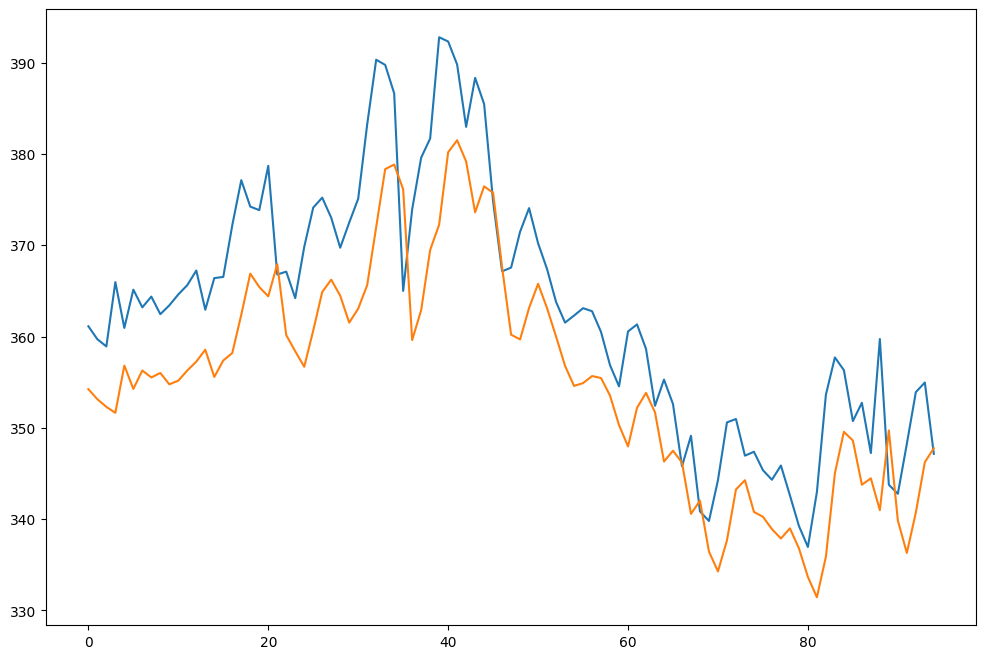

In [18]:
y_pred = md2.predict(X_test, verbose=0, batch_size=32)

y_pred_raw = scaler.inverse_transform(y_pred)
y_test_raw = scaler.inverse_transform(y_test)

plt.figure(figsize=(12,8))

plt.plot(y_test_raw, label='True Price')
plt.plot(y_pred_raw, label='predicted price')


### Exercise 1(i) (3 points)

Using the results from parts 1(g) and 1(h), what model would you use to predict the `Close` price of mastercard? Be specific.

Based on my results i would use model 1 because it has the lowest MAE